# Accessing HELP data through VO protocol

This notebook gives a simple example of querying the HELP Virtual Observatory database for sources around a position, as well as images cutouts.

*Note: The queries are based on the first ingestion of the images in the database. Depending on how we make the final ingestion, we may want to rework them.*

In [1]:
import pyvo as vo
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
BASE_URL = "https://herschel-vos.phys.sussex.ac.uk"

## The position

We are looking for a position in the COSMOS field; it is given as an astropy `SkyCoord` object.  The `size` is the radius of the search we are performing (with it's unit).

In [4]:
pos = SkyCoord(150.12 * u.deg, 2.25 * u.deg)
size = 1 * u.arcmin

# Cone-search of the sources

We are using the simple cone search (SCS) access to main help catalogue in the VO database.  The URL to access the service is given on the VoX page: https://herschel-vos.phys.sussex.ac.uk/herschelhelp/q/cone/info in the *you can access* with **scs.xml** section (once VO is registred in a registry, it will be possible to query the registry to get the URL).

In [5]:
cone_search_service = vo.dal.SCSService(f"{BASE_URL}/herschelhelp/q/cone/scs.xml")

Searching the cone search service needs the position and the radius of the search.

In [6]:
sources = cone_search_service.search(pos=pos, radius=size)

The search returns a `pyvo.dal.scs.SCSResults` that can be easily converted to an astropy Table.

In [7]:
sources = sources.to_table()

In [8]:
sources

<Table length=639>
field            help_id           ... flag_optnir_obs flag_optnir_det
                                   ...                                
object            object           ...      int16           int16     
------ --------------------------- ... --------------- ---------------
COSMOS HELP_J100027.286+021406.530 ...               3               3
COSMOS HELP_J100027.197+021408.431 ...               3               3
COSMOS HELP_J100025.890+021419.975 ...               3               3
COSMOS HELP_J100025.920+021421.206 ...               3               1
COSMOS HELP_J100025.657+021424.360 ...               3               1
COSMOS HELP_J100025.983+021425.761 ...               3               0
COSMOS HELP_J100025.443+021427.808 ...               3               3
COSMOS HELP_J100025.505+021432.263 ...               3               3
COSMOS HELP_J100025.858+021428.285 ...               3               0
   ...                         ... ...             ...             ...
COSMOS HELP_J100029.937+021551.931 ...               3               3
COSMOS HELP_J100030.159+021551.676 ...               3               3
COSMOS HELP_J100030.267+021552.495 ...               3               1
COSMOS HELP_J100030.511+021553.896 ...               3               3
COSMOS HELP_J100031.455+021542.009 ...               3               3
COSMOS HELP_J100032.406+021442.003 ...               3               1
COSMOS HELP_J100032.519+021444.521 ...               3               3
COSMOS HELP_J100032.473+021511.965 ...               3               1
COSMOS HELP_J100032.613+021512.160 ...               3               1
COSMOS HELP_J100032.565+021515.716 ...               3               3

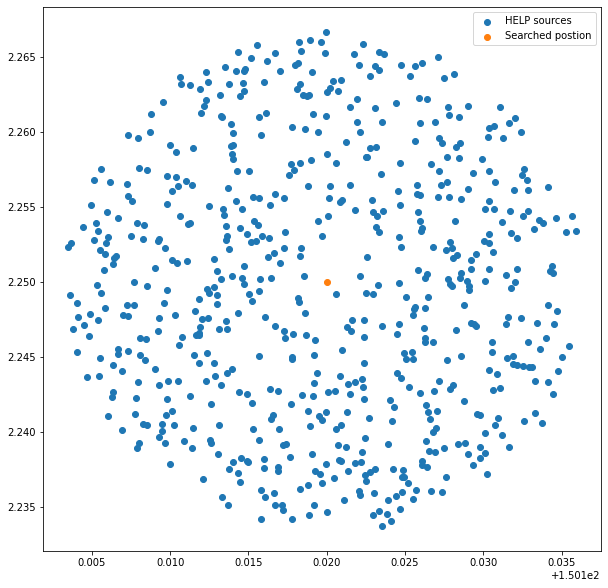

In [9]:
fig1, ax1 = plt.subplots()
ax1.scatter(sources['ra'], sources['dec'], label="HELP sources")
ax1.scatter(pos.ra, pos.dec, label="Searched postion")
ax1.legend()

## Cut-out from the images

To get cutouts from the images, we are using the simple image access protocol (SIAP). SIAP is simple for maps that overlaps (or contains, or are contained by) a region of interest defined by a position and a radius.  The cutout service has additional parameters as the `cutoutSize` that allows the server to return a link to a cropped version of the map.

As for the cone search, we need the endpoint of the SIAP service of the cutout ressource that can be found on https://herschel-vos.phys.sussex.ac.uk/herschel_maps/q/cutout/info

In [10]:
cutout_service = vo.dal.SIAService(f"{BASE_URL}/herschel_maps/q/cutout/siap.xml")

We can ask for the service parameters that are additional to the standard SIAP parameters:

In [11]:
cutout_service.params

[<PARAM ID="INPUT_POS" arraysize="*" datatype="char" name="INPUT:POS" ucd="pos.eq" unit="deg" value=""/>,
 <PARAM ID="INPUT_SIZE" arraysize="*" datatype="char" name="INPUT:SIZE" unit="deg" value=""/>,
 <PARAM ID="INPUT_INTERSECT" arraysize="*" datatype="char" name="INPUT:INTERSECT" value="OVERLAPS"/>,
 <PARAM ID="INPUT_FORMAT" arraysize="*" datatype="char" name="INPUT:FORMAT" value="GRAPHIC"/>,
 <PARAM ID="INPUT_bandpassId" arraysize="*" datatype="char" name="INPUT:bandpassId" ucd="VOX:BandPass_ID" value=""/>,
 <PARAM ID="INPUT_type" arraysize="*" datatype="char" name="INPUT:type" ucd="meta.code" value=""/>,
 <PARAM ID="INPUT_cutoutSize" datatype="float" name="INPUT:cutoutSize" unit="deg" value="0.1"/>,
 <PARAM ID="INPUT_RESPONSEFORMAT" arraysize="*" datatype="char" name="INPUT:RESPONSEFORMAT" ucd="meta.code.mime" value=""/>,
 <PARAM ID="INPUT_MAXREC" datatype="int" name="INPUT:MAXREC" value="0"/>,
 <PARAM ID="INPUT_VERB" datatype="int" name="INPUT:VERB" value="0"/>]

As we can see, there is `cutoutSize` that is use the give the size of the cutout we want but there are also parameters added by HELP that are the `type` which defines that kind of image: `image`, `error`, or `exposure`; and the `bandpassId` that identifies the SPIRE band: `SPIRE250`, `SPIRE350`, or `SPIRE500`.

Note that there are to size parameters: `size` is the **radius** defining the region of interest around the position that is use to look for maps.  It's a standard SIAP parameter and is given with its associated unit; `cutoutSize` is the **width** of the cutout around the position the user want in the maps overlapping the region of interest; it may be different that the size (and should be the double of it with you want the cutout corresponding to the searched region) and must be given in degrees without unit.

Let's look for the SPIRE250 image and error maps.

In [12]:
images = cutout_service.search(
    pos=pos, 
    size=size, 
    cutoutSize=2*size.to(u.deg).value,
    bandpassId='SPIRE250',
    type=['image', 'error']
)

As for the cone search, the result is a `pyvo.dal.sia.SIAResults` that can be converted to a table.

In [13]:
images = images.to_table()
images

accref,mime,accsize,centerAlpha,centerDelta,imageTitle,instId,dateObs,nAxes,pixelSize,pixelScale,refFrame,wcs_equinox,wcs_projection,wcs_refPixel,wcs_refValues,wcs_cdmatrix,bandpassId,bandpassUnit,bandpassRefval,bandpassHi,bandpassLo,pixflags,coverage,field,type
,,byte,deg,deg,,,d,,pix,deg / pix,,yr,,pix,deg,deg / pix,,,m,m,m,,deg,,
object,object,int32,float64,float64,object,object,float64,int32,object,object,object,float32,str3,object,object,object,object,object,float64,float64,float64,object,object,object,object
https://herschel-vos.phys.sussex.ac.uk/getproduct/herschel_maps/data/COSMOS-Nest_error_250_SMAP_v6.0.fits?sdec=0.0333333333333&dec=2.25&ra=150.12&sra=0.0333590519534,image/fits,799,150.12,2.25,COSMOS SPIRE250 (error),SPIRE,--,2,[1643 1711],[0.00166667 0.00166667],ICRS,2000.0,TAN,[9.999869734149684 -10.000042508102638],[150.12 2.25],[-0.00166667 0.0 0.0 0.00166667],SPIRE250,m,--,--,--,,[151.4878373528349 0.7918563074747172 151.49047253147396 3.6404558482458373 148.74963977252614 3.6404558482458373 148.7522749511652 0.7918563074747172],COSMOS,error
https://herschel-vos.phys.sussex.ac.uk/getproduct/herschel_maps/data/COSMOS-Nest_image_250_SMAP_v6.0.fits?sdec=0.0333333333333&dec=2.25&ra=150.12&sra=0.0333590519534,image/fits,799,150.12,2.25,COSMOS SPIRE250 (image),SPIRE,--,2,[1643 1711],[0.00166667 0.00166667],ICRS,2000.0,TAN,[9.999869734149684 -10.000042508102638],[150.12 2.25],[-0.00166667 0.0 0.0 0.00166667],SPIRE250,m,--,--,--,,[151.4878373528349 0.7918563074747172 151.49047253147396 3.6404558482458373 148.74963977252614 3.6404558482458373 148.7522749511652 0.7918563074747172],COSMOS,image


We can see that the URL to the cutout FITS is in the `accref` column.  We can feed the URL directly to `fits.open` to get directly the image.

In [14]:
spire250_image_map = fits.open(
    images[images['type'] == 'image'][0]['accref']
)

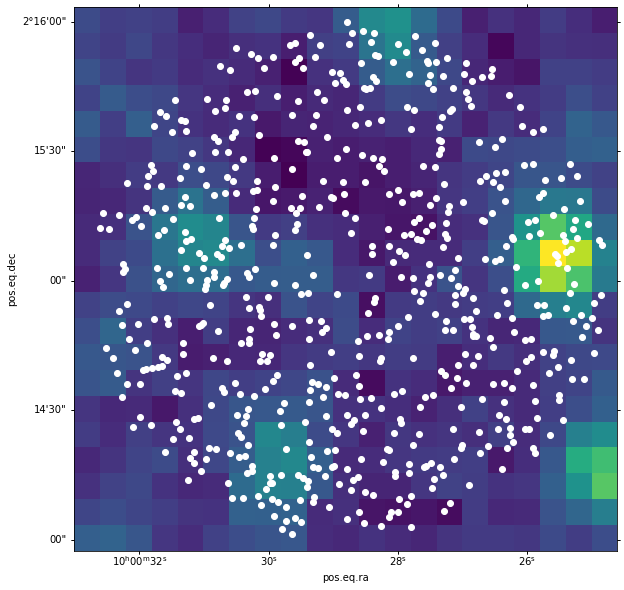

In [15]:
wcs = WCS(spire250_image_map[0].header)
fig2, ax2 = plt.subplots(subplot_kw={'projection': wcs})
ax2.imshow(spire250_image_map[0].data, origin='lower')
ax2.scatter(sources['ra'], sources['dec'], transform=ax2.get_transform('fk5'), c='white')